# ***Amazon Review sentiment analysis***

In [1]:
from tkinter import Grid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import scipy
import warnings 
warnings.filterwarnings("ignore")
import pickle
import re
sns.set_theme(style='whitegrid')

In [82]:
# Reading dataset using pickle
with open (r'C:\Users\91959\Amazon_reviews_sentiment_analysis\Dataset\raw_data.pickle','rb') as f: raw_data = pickle.load(f)

***Feature Names and their Explanation***

- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- vote - helpful votes of the review
- style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)
- image - images that users post after they have received the product
- Verfied - verified user review(bool)


#### **Basic EDA**

In [7]:
raw_data.columns

Index(['overall', 'verified', 'reviewtime', 'reviewerid', 'asin',
       'reviewername', 'reviewtext', 'summary', 'unixreviewtime', 'vote',
       'style', 'image'],
      dtype='object')

In [83]:
# Renaming feature names to make it more readable

raw_data.rename(columns={'overall':'ratings','vote':'helpfullness_vote',\
    'reviewtime':'review_time','reviewerid':'reviewer_id','reviewername':'reviewer_name',
    'reviewtext':'review_text','unixreviewtime':'unix_review_time','asin':'product_id'}, inplace=True)

In [117]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2562850 entries, 0 to 2562849
Data columns (total 8 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   reviewer_id        object
 1   product_id         object
 2   verified           bool  
 3   review_time        object
 4   helpfullness_vote  int32 
 5   summary            object
 6   review_text        object
 7   ratings            int32 
dtypes: bool(1), int32(2), object(5)
memory usage: 119.8+ MB


#### **Missing value analysis**

In [18]:
def missing_values(df):
    return df.isna().sum(axis = 0) / len(df) * 100

In [19]:
missing_values(raw_data)

ratings               0.000000
verified              0.000000
review_time           0.000000
reviewer_id           0.000000
asin                  0.000000
reviewer_name         0.018243
review_text           0.067086
summary               0.032783
unix_review_time      0.000000
helpfullness_vote    82.742465
style                48.546104
image                98.896641
dtype: float64

In [21]:
raw_data['style'].unique()

array([nan, "{'Format:': ' Hardcover'}", "{'Format:': ' DVD-ROM'}", ...,
       "{'Color:': ' 1pcs'}", "{'Color:': ' Matte White'}",
       "{'Color:': ' c2'}"], dtype=object)

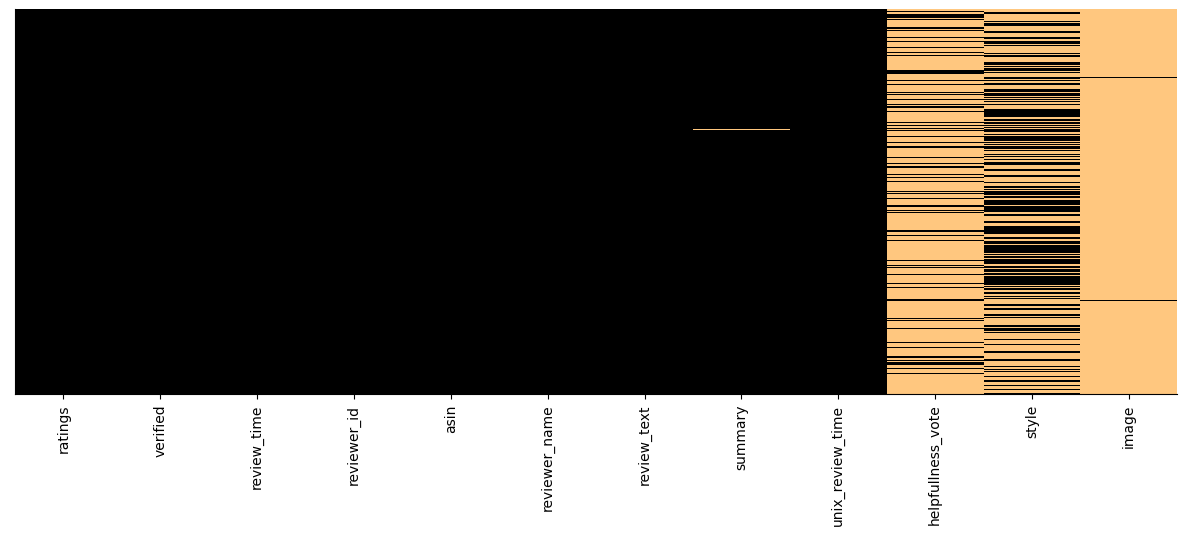

In [25]:
plt.figure(figsize=(15,5))
sns.heatmap(raw_data.isna(), cbar=False , yticklabels=False,cmap= 'copper')
sns.despine()

In [84]:
'''
From the above analysis we can find image, style and helpfullness_vote features has
most amount of missing values so we can drop style and image features and impute the helpfullness_vote 
feature with 0 since it may be useful for out further analysis.
'''

raw_data.drop(columns= ['style','image'], inplace=True)

In [85]:
raw_data.head(2)

,ratings,verified,review_time,reviewer_id,asin,reviewer_name,review_text,summary,unix_review_time,helpfullness_vote
0,1.0,True,"06 9, 2014",A21ROB4YDOZA5P,0439381673,Mary M. Clark,I used to play this game years ago and loved i...,Did not like this,1402272000,NaN
1,3.0,True,"05 10, 2014",A3TNZ2Q5E7HTHD,0439381673,Sarabatya,The game itself worked great but the story lin...,Almost Perfect,1399680000,NaN


In [86]:
raw_data.drop(columns=['reviewer_name','unix_review_time'],inplace= True)
# dropped reviewer_name and unix time features because we have reviewer_id and review_time features

In [87]:
display(raw_data.iloc[:5].T)

,0,1,2,3,4
ratings,1.0,3.0,4.0,1.0,4.0
verified,True,True,True,True,True
review_time,"06 9, 2014","05 10, 2014","02 7, 2014","02 7, 2014","01 16, 2014"
reviewer_id,A21ROB4YDOZA5P,A3TNZ2Q5E7HTHD,A1OKRM3QFEATQO,A2XO1JFCNEYV3T,A19WLPIRHD15TH
asin,0439381673,0439381673,0439381673,0439381673,0439381673
review_text,I used to play this game years ago and loved i...,The game itself worked great but the story lin...,I had to learn the hard way after ordering thi...,The product description should state this clea...,I would recommend this learning game for anyon...
summary,Did not like this,Almost Perfect,DOES NOT WORK WITH MAC OS unless it is 10.3 or...,does not work on Mac OSX,Roughing it
helpfullness_vote,NaN,NaN,15,11,NaN


In [88]:
raw_data['helpfullness_vote'] = raw_data[['helpfullness_vote']].fillna(0)

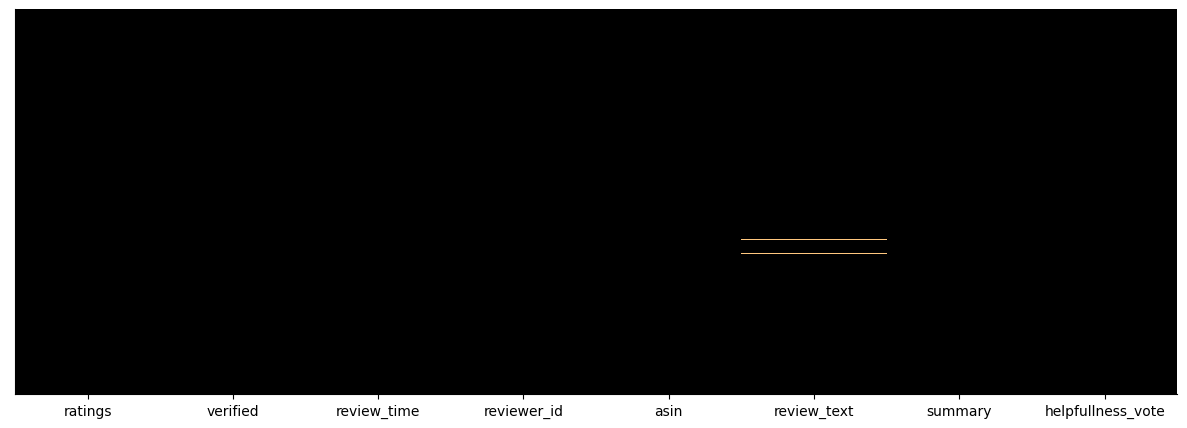

In [89]:
plt.figure(figsize=(15,5))
sns.heatmap(raw_data.isna(), cbar=False , yticklabels=False,cmap= 'copper')
sns.despine()

In [90]:
missing_values(raw_data)

ratings              0.000000
verified             0.000000
review_time          0.000000
reviewer_id          0.000000
asin                 0.000000
review_text          0.067086
summary              0.032783
helpfullness_vote    0.000000
dtype: float64

In [91]:
print( "Number of missing rows in review_text: ", raw_data[raw_data['review_text'].isna()].shape[0])
print( "Number of missing rows in summary: ", raw_data[raw_data['summary'].isna()].shape[0])

Number of missing rows in review_text:  1721
Number of missing rows in summary:  841


Since the number of rows that missing in review_text and summary features are very less comparing to our entire dataset its safe to assume that we can drop them completely.

In [92]:
raw_data = raw_data.dropna()
missing_values(raw_data)

ratings              0.0
verified             0.0
review_time          0.0
reviewer_id          0.0
asin                 0.0
review_text          0.0
summary              0.0
helpfullness_vote    0.0
dtype: float64

In [93]:
print(raw_data.info())
print(raw_data.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2562850 entries, 0 to 2565348
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ratings            float64
 1   verified           bool   
 2   review_time        object 
 3   reviewer_id        object 
 4   asin               object 
 5   review_text        object 
 6   summary            object 
 7   helpfullness_vote  object 
dtypes: bool(1), float64(1), object(6)
memory usage: 158.9+ MB
None
(2562850, 8)


In [94]:
raw_data = raw_data[['reviewer_id','product_id','verified','review_time','helpfullness_vote','summary','review_text','ratings']]

In [95]:
raw_data = raw_data.reset_index(drop= True)

In [118]:
raw_data.head(2)

,reviewer_id,product_id,verified,review_time,helpfullness_vote,summary,review_text,ratings
0,A21ROB4YDOZA5P,0439381673,True,"06 9, 2014",0,Did not like this,I used to play this game years ago and loved i...,1
1,A3TNZ2Q5E7HTHD,0439381673,True,"05 10, 2014",0,Almost Perfect,The game itself worked great but the story lin...,3


#### Converting features to correct datatype

In [97]:
raw_data['ratings'].unique()

array([1., 3., 4., 5., 2.])

In [98]:
raw_data['ratings'] = raw_data['ratings'].astype('int')

In [107]:
raw_data['helpfullness_vote'] = raw_data['helpfullness_vote'].str.replace(',','')

In [109]:
raw_data['helpfullness_vote'] = raw_data['helpfullness_vote'].fillna(0)

In [111]:
raw_data['helpfullness_vote'] =  raw_data['helpfullness_vote'].astype(str).astype(int)

In [55]:
raw_data['review_time'] = pd.to_datetime(raw_data['review_time'])

In [62]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2562850 entries, 0 to 2562849
Data columns (total 8 columns):
 #   Column             Dtype         
---  ------             -----         
 0   reviewer_id        object        
 1   product_id         object        
 2   verified           bool          
 3   review_time        datetime64[ns]
 4   helpfullness_vote  int32         
 5   summary            object        
 6   review_text        object        
 7   ratings            int32         
dtypes: bool(1), datetime64[ns](1), int32(2), object(4)
memory usage: 119.8+ MB


#### Basic Feature Extraction
Extracting some useful information from the textual data before cleaning them since it may come useful for further analysis

1) Number of stopwords in review_text

In [2]:
from nltk.corpus import stopwords
import string
import nltk
stop = stopwords.words('english')

In [159]:
raw_data['stopwords'] = raw_data['review_text'].apply(lambda x: len([x for x in x.split() if x in stop]))
raw_data[['review_text','stopwords']].head()

,review_text,stopwords
0,I used to play this game years ago and loved i...,11
1,The game itself worked great but the story lin...,8
2,I had to learn the hard way after ordering thi...,34
3,The product description should state this clea...,11
4,I would recommend this learning game for anyon...,5


2) Number of Punctuations in review_text

In [163]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return count

raw_data['punctuation'] = raw_data['review_text'].apply(lambda x: count_punct(x))

3) Number of hastags in review_text

In [166]:
raw_data['hastags'] = raw_data['review_text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
raw_data[['review_text','hastags']].head()

,review_text,hastags
0,I used to play this game years ago and loved i...,0
1,The game itself worked great but the story lin...,0
2,I had to learn the hard way after ordering thi...,0
3,The product description should state this clea...,0
4,I would recommend this learning game for anyon...,0


In [196]:
print("Number of rows that has hastags present in out dataset:", raw_data[raw_data['hastags'] > 0].shape[0])

Number of hastags present in out dataset: 6048


In [195]:
raw_data[raw_data['hastags']>0].shape

(6048, 11)

4) Number of numericals in review_text

In [198]:
raw_data['numerics'] = raw_data['review_text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
raw_data[['review_text','numerics']].head()

,review_text,numerics
0,I used to play this game years ago and loved i...,0
1,The game itself worked great but the story lin...,0
2,I had to learn the hard way after ordering thi...,1
3,The product description should state this clea...,0
4,I would recommend this learning game for anyon...,0


In [199]:
print("Number of rows that has numericals present in out dataset:", raw_data[raw_data['numerics'] > 0].shape[0])

Number of rows that has numericals present in out dataset: 577402


#### **Data Preprocessing**

1) Transform all our reviews into lower case, this prevents us from getting multiple copies of same words

In [4]:
raw_data['review_text'] = raw_data['review_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
raw_data['review_text'].head()

0    used play game years ago loved found work comp...
1    game worked great story line videos would neve...
2    learn hard way ordering macbook pro doesnt wor...
3    product description state clearly cd box produ...
4    would recommend learning game anyone likes lea...
Name: review_text, dtype: object

2. Remove all the punctuations from the reviews

In [7]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
raw_data['review_text'] = raw_data['review_text'].str.replace("[!#$%&'()*+,-./:;<=>?@[\]^_`{|}~]",'')
raw_data['review_text'].head()

0    used play game years ago loved found work comp...
1    game worked great story line videos would neve...
2    learn hard way ordering macbook pro doesnt wor...
3    product description state clearly cd box produ...
4    would recommend learning game anyone likes lea...
Name: review_text, dtype: object

3. Remove all the stopwords from the reviews

In [9]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [10]:
raw_data['review_text'] = raw_data['review_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
raw_data['review_text'].head(5)

0    used play game years ago loved found work comp...
1    game worked great story line videos would neve...
2    learn hard way ordering macbook pro doesnt wor...
3    product description state clearly cd box produ...
4    would recommend learning game anyone likes lea...
Name: review_text, dtype: object

4. Remove all the URL from the reviews 

In [11]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [12]:
raw_data['review_text'] = raw_data['review_text'].apply(lambda x: remove_url(x))

5. Remove HTML tags from the reviews

In [13]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

raw_data['review_text'] = raw_data['review_text'].apply(lambda x: remove_html(x))

6. Remove all the emojis from the reviews

In [14]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [15]:
raw_data['review_text'] = raw_data['review_text'].apply(lambda x: remove_emoji(x))

In [40]:
def clean_text(text):
    text = text.lower() # Make text lower case
    text = re.sub('\[.*?\]', '', text) # Remove text in square brackets
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #Remove punctuation
    text = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    text = re.sub("[‘’“”…!#$%&'()*+,-./:;<=>?@[\]^_`{|}~]", '', text) # Remove some more punctuations
    text = re.sub('<.*?>','',text) # Remove HTML tags
    text = re.sub('https?://\S+|www\.\S+','',text) # Remove URL
    text = re.sub('\n', '', text)
    return text


In [42]:
raw_data['review_text'] = raw_data['review_text'].apply(lambda x : clean_text(x))

In [45]:
raw_data['summary'] = raw_data['summary'].apply(lambda x: clean_text(x))

In [49]:
def remove_stopwords(text):
    text = text.lower()
    text = [word for word in text.split() if word not in stop]
    text = ' '.join(text)
    return text

In [51]:
raw_data['summary'] = raw_data['summary'].apply(lambda x : remove_stopwords(x))

Number of words in the reviews 

In [76]:
raw_data['word_count'] = raw_data['review_text'].apply(lambda x: len(str(x).split(" ")))
raw_data[['review_text','word_count']].head()

,review_text,word_count
0,used play game years ago loved found work comp...,15
1,game worked great story line videos would neve...,18
2,learn hard way ordering macbook pro doesnt wor...,37
3,product description state clearly cd box produ...,12
4,would recommend learning game anyone likes lea...,13


Checking the frequency of the words in the review text to find and add some custom stop words

In [72]:
word_frequency = pd.Series(' '.join(raw_data['review_text'].iloc[:100000]).split()).value_counts()[:50]
word_frequency

game          236640
one            53362
games          52323
like           50174
get            44541
great          40829
play           40252
good           35888
time           32267
graphics       30460
fun            29637
first          27146
really         25827
best           25309
even           25288
dont           24204
also           23265
much           22656
would          22283
well           20867
new            20632
played         20409
still          19374
playing        19028
buy            18377
better         17777
many           16991
ever           16306
characters     16135
story          15564
go             15197
make           14969
way            14583
love           14313
got            13738
people         13442
system         13272
little         13244
think          13026
gameplay       12962
back           12923
want           12923
im             12581
could          12315
find           12038
different      12005
say            11773
ive          

In [73]:
# from the frequency of the words we can identify some of the words are commonly used filler words

custom_stopwords = ["im","ive",]

In [74]:
stop.extend(custom_stopwords)

In [75]:
raw_data['review_text'] = raw_data['review_text'].apply(lambda x: remove_stopwords(x))

In [77]:
raw_data['summary'] = raw_data['summary'].apply(lambda x: remove_stopwords(x))

In [78]:
word_frequency = pd.Series(' '.join(raw_data['review_text'].iloc[:100000]).split()).value_counts()[:50]
word_frequency

game          236640
one            53362
games          52323
like           50174
get            44541
great          40829
play           40252
good           35888
time           32267
graphics       30460
fun            29637
first          27146
really         25827
best           25309
even           25288
dont           24204
also           23265
much           22656
would          22283
well           20867
new            20632
played         20409
still          19374
playing        19028
buy            18377
better         17777
many           16991
ever           16306
characters     16135
story          15564
go             15197
make           14969
way            14583
love           14313
got            13738
people         13442
system         13272
little         13244
think          13026
gameplay       12962
want           12923
back           12923
could          12315
find           12038
different      12005
say            11773
thing          11364
lot          

#### **Duplicate Review Analysis**

One of the major issues in the review analysis are the duplicate and fake and paid reviews which are made to give 
good reputation for the product.

In [82]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2562850 entries, 0 to 2562849
Data columns (total 13 columns):
 #   Column             Dtype         
---  ------             -----         
 0   reviewer_id        object        
 1   product_id         object        
 2   verified           bool          
 3   review_time        datetime64[ns]
 4   helpfullness_vote  int32         
 5   summary            object        
 6   review_text        object        
 7   ratings            int32         
 8   stopwords          int64         
 9   punctuation        int64         
 10  hastags            int64         
 11  numerics           int64         
 12  word_count         int64         
dtypes: bool(1), datetime64[ns](1), int32(2), int64(5), object(4)
memory usage: 217.5+ MB


In [84]:
raw_data.describe().round(1)

,helpfullness_vote,ratings,stopwords,punctuation,hastags,numerics,word_count
count,2562850.0,2562850.0,2562850.0,2562850.0,2562850.0,2562850.0,2562850.0
mean,1.5,4.0,30.8,12.2,0.0,0.4,36.9
std,12.9,1.4,61.9,27.5,0.1,1.3,73.5
min,0.0,1.0,0.0,0.0,0.0,0.0,1.0
25%,0.0,3.0,3.0,2.0,0.0,0.0,6.0
50%,0.0,5.0,12.0,4.0,0.0,0.0,14.0
75%,0.0,5.0,32.0,11.0,0.0,0.0,37.0
max,5154.0,5.0,2737.0,3172.0,40.0,236.0,3616.0


1.Using Helpfull vote feature

In [7]:
duplicate = raw_data[['review_text','verified','helpfullness_vote']]

In [13]:
duplicate.sort_values(by='helpfullness_vote', ascending=False).head(50)

,review_text,verified,helpfullness_vote
1536670,ac unity true nextgen fact nextgen isnt even f...,False,5154
501970,last years served constant whipping post thous...,False,4108
576002,last years served constant whipping post thous...,False,4108
824735,great system easy use futuristic onscreen inte...,True,3744
721859,intro years wanting wii finally got one course...,False,3005
576397,hesitant write review long playing classes don...,True,2986
502365,hesitant write review long playing classes don...,True,2986
459445,one respect blizzard setting release date knew...,False,2474
533477,one respect blizzard setting release date knew...,False,2474
242206,got hands xbox wii launch day good specific ta...,False,2403


#### Inference: </br>
From this initial analysis only we can find lot of reviews with high number of votes are almost same
reviews with same number of votes they can be assumed as duplicate reviews or fake reviews made by the company itself


2. using stopwords and word count

In [14]:
duplicate_2 = raw_data[['review_text','stopwords','word_count']]
duplicate_2.sort_values(by='stopwords',ascending = False).head(50)

'''
From this we can again find there is lot of fake and duplicate reviews 
'''

,review_text,stopwords,word_count
575734,played diablo hours gaming diablo say game goo...,2737,2947
501702,played diablo hours gaming diablo say game goo...,2737,2947
951991,review one posted standard edition game howeve...,2614,2893
48430,shigeru miyamoto created masterpiece created m...,2596,2909
723842,review whole game single multiplayer almost ye...,2542,2900
853514,deal reviewing game steam account annoyances a...,2507,2820
616798,edited brevityreadability corrected typos cont...,2493,2694
721839,first something important share yall last zeld...,2392,2954
958454,witcher assassin kings developers cd projekt r...,2379,2924
289975,overview since point reviews help others make ...,2359,2811


Comparing all the feature for duplicate reviews 

In [15]:
raw_data.columns

Index(['reviewer_id', 'product_id', 'verified', 'review_time',
       'helpfullness_vote', 'summary', 'review_text', 'ratings', 'stopwords',
       'punctuation', 'hastags', 'numerics', 'word_count'],
      dtype='object')

In [16]:
duplicate_check = raw_data[['reviewer_id','helpfullness_vote','review_text','ratings',\
    'stopwords','word_count']]

In [18]:
duplicate_check.sort_values(by= 'helpfullness_vote',ascending=False).head(50)

,reviewer_id,helpfullness_vote,review_text,ratings,stopwords,word_count
1536670,A3NKZH4M5I23ML,5154,ac unity true nextgen fact nextgen isnt even f...,1,178,219
501970,A1USXRKI457YY6,4108,last years served constant whipping post thous...,5,260,346
576002,A1USXRKI457YY6,4108,last years served constant whipping post thous...,5,260,346
824735,A3I2AIBC3CYQMH,3744,great system easy use futuristic onscreen inte...,4,539,752
721859,A2PQ3WXMKCT4NX,3005,intro years wanting wii finally got one course...,5,513,628
576397,A269RDUA5T3X75,2986,hesitant write review long playing classes don...,1,788,900
502365,A269RDUA5T3X75,2986,hesitant write review long playing classes don...,1,788,900
459445,A74TA8X5YQ7NE,2474,one respect blizzard setting release date knew...,3,374,471
533477,A74TA8X5YQ7NE,2474,one respect blizzard setting release date knew...,3,374,471
242206,A3V6Z4RCDGRC44,2403,got hands xbox wii launch day good specific ta...,5,497,604


From this we can identify that the reviews are indeed duplicate reviews because the reviewer id and the helpfullness_vote and stopwords and wordcount of the reviews are almost the same, hence they can be dropped.

In [24]:
print("Number of rows before dropping duplicate values:", raw_data.shape[0])
print("Number of rows after dropping duplicate values:", raw_data.drop_duplicates(subset='review_text').shape[0])

Number of rows before dropping duplicate values: 2562850
Number of rows after dropping duplicate values: 2102711


In [81]:
raw_data = raw_data.drop_duplicates(subset= 'review_text')

In [82]:
raw_data.shape

(2102711, 13)

In [30]:
raw_data.sort_values(by='word_count', ascending=False).review_text.head(50)

233540     best game ever best game ever best game ever b...
1211176    fantasy creating experience someone else going...
721957     super mario galaxy unfortunately unforgivably ...
2186422    remember kid thinking whoa dragon warrior seri...
878652     text permission heinkill battle britain gamehu...
721839     first something important share yall last zeld...
8668       history pokmon media franchise spans decade wo...
501702     played diablo hours gaming diablo say game goo...
850523     dragon age origins ultimate edition origins dl...
958454     witcher assassin kings developers cd projekt r...
48430      shigeru miyamoto created masterpiece created m...
723842     review whole game single multiplayer almost ye...
951991     review one posted standard edition game howeve...
598345     time favorite call duty especially custom zomb...
853514     deal reviewing game steam account annoyances a...
289975     overview since point reviews help others make ...
1838681    youve ever wa

In [32]:
# Lets check for missing values:
missing_values(raw_data)

reviewer_id          0.0
product_id           0.0
verified             0.0
review_time          0.0
helpfullness_vote    0.0
summary              0.0
review_text          0.0
ratings              0.0
stopwords            0.0
punctuation          0.0
hastags              0.0
numerics             0.0
word_count           0.0
dtype: float64

In [38]:
raw_data.describe().round(1)

,helpfullness_vote,ratings,stopwords,punctuation,hastags,numerics,word_count
count,2102711.0,2102711.0,2102711.0,2102711.0,2102711.0,2102711.0,2102711.0
mean,1.6,3.9,35.4,13.9,0.0,0.5,42.1
std,13.1,1.4,64.7,28.9,0.1,1.4,76.7
min,0.0,1.0,0.0,0.0,0.0,0.0,1.0
25%,0.0,3.0,7.0,2.0,0.0,0.0,9.0
50%,0.0,5.0,15.0,5.0,0.0,0.0,18.0
75%,0.0,5.0,37.0,13.0,0.0,1.0,43.0
max,5154.0,5.0,2737.0,3172.0,40.0,236.0,3616.0


Inference: </br>

From this description we can identify features having extreme values 

Stopwords

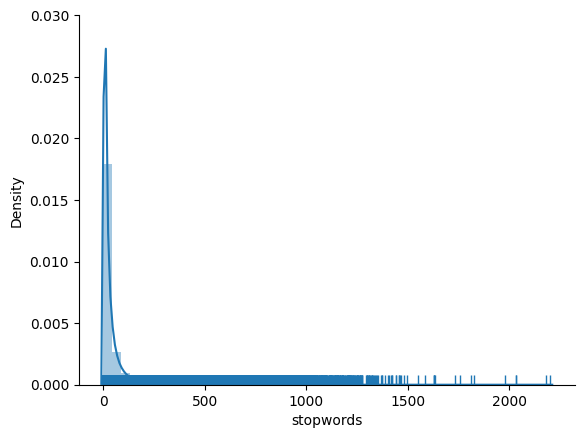

In [4]:
sns.distplot(raw_data.stopwords,rug=True)
sns.despine()

In [5]:
raw_data = raw_data[raw_data['stopwords'] <= 2000]

Punctuation

<Figure size 1500x500 with 0 Axes>

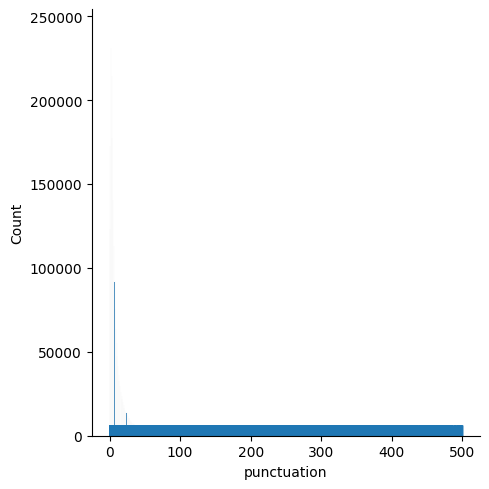

In [6]:
plt.figure(figsize=(15,5))
sns.displot(raw_data.punctuation, rug=True)
sns.despine()

In [104]:
raw_data.sort_values(by= 'punctuation', ascending=False)['review_text'].head(50)

1138991    brain age concentration training wellnamed foc...
479187     control family fun individual fun overall desc...
958545     witcher sets new highbar roleplaying games rpg...
767748     testing keyboard three weeks ready rate typing...
288830     although may become costly memory cards items ...
50215      written two zelda reviews one original nes rel...
1536416    sit typing listening soundtrack game slightly ...
587857     february update darth mod soon version freely ...
658639     loved bioshock became immediately immersed spe...
1432927    prologue video game enthusiast isnt console ha...
1728978    introduction xbox controller using play pc gam...
1345463    astro fantastic company buy boast excellent su...
311549     wanted like game market swamped blow alien ide...
1126857    may know mad lust envy headfi shin czraven cri...
1027116    sure ill receive flak review opinion game exci...
26012      xena game review older game playstation thats ...
857044     owned every v

In [93]:
raw_data[raw_data['punctuation'] >= 500]['review_text']

4672       back late wrote two articles defunct game webs...
8668       history pokmon media franchise spans decade wo...
10851      yes heard final fantasy vii overrated stay min...
16438      getting tired microsoft combat flight simulato...
19969      metal gear solid cared two different genres vi...
                                 ...                        
2491180    warning long review honestly like walkthrough ...
2502771    update jan terrible product worst support ever...
2520633    legend zelda favorite series gaming lifelong h...
2533659    wanted wanted create guide help interested pur...
2547402    summary price great android windows bluetooth ...
Name: review_text, Length: 519, dtype: object

In [94]:
raw_data= raw_data[raw_data.punctuation <= 500]

Hastags

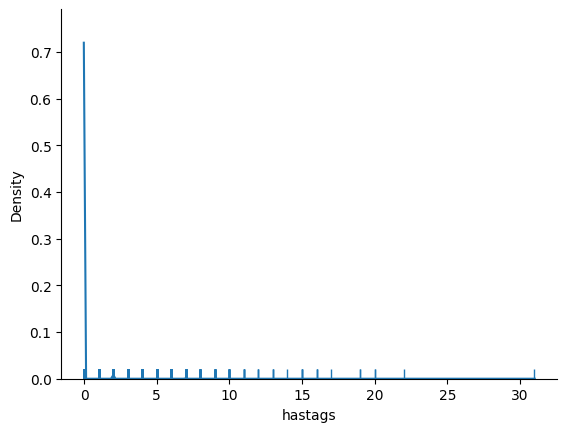

In [7]:
sns.distplot(raw_data['hastags'], rug=True,hist=False)
sns.despine()

In [24]:
raw_data[raw_data['hastags']>=1].shape

(5622, 13)

In [5]:
# We can drop the feature since majority of the rows doesnt have hastags in it 
raw_data.drop(columns= 'hastags', inplace=True)

Numerics

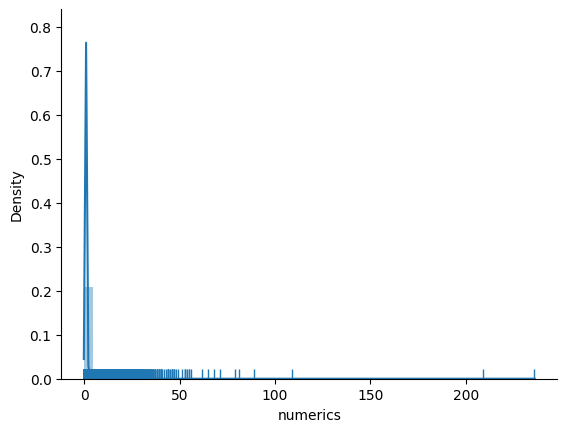

In [8]:
sns.distplot(raw_data['numerics'], rug=True)
sns.despine()

In [12]:
raw_data[raw_data.numerics >50].sort_values(by='numerics',ascending=False)['review_text']

145442     queen bird queen autumn leaves queens double r...
145443     ice water ill witch illusionist faceless mage ...
924637     updated positive review update review dead spa...
49759      statsic first two boss due gutsman cut man tak...
666771     heard early game supposed good actually bought...
1295758    say wasnt biggest fan madden nfl release sony ...
1053765    pilot years started flying kites radio control...
679345     far one best games ever experienced game unbel...
1148840    age mid remember youngster putting quarters to...
1078282    first question ask iswith dance central best t...
503726     cant play hp touch one two years old get diabl...
1308542    like dance theyve added great new features the...
2188122    last mega man game released nineteen system pr...
2377421    game default car set bit like eating cardboard...
379118     far better ace combat ac zero includes full re...
2078014    resident evil came blew entire gaming world aw...
2328635    would known l

In [51]:
# From that we can tell most of the sentences contains very less numer of numerics

raw_data['numerics'].value_counts(normalize=True*100)[:10]

0    0.740641
1    0.153956
2    0.053482
3    0.022373
4    0.011421
5    0.006287
6    0.003780
7    0.002425
8    0.001538
9    0.001072
Name: numerics, dtype: float64

In [6]:
raw_data.drop(columns='numerics', inplace=True)

Word_count

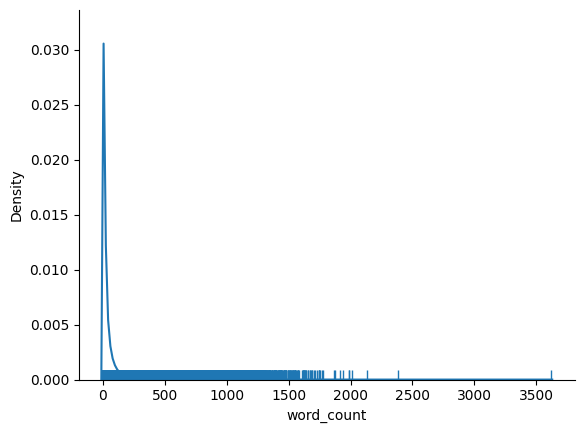

In [13]:
sns.distplot(raw_data.word_count,rug=True,hist=False)
sns.despine()

In [57]:
raw_data[raw_data['word_count'] > 1500].sort_values(by='word_count',ascending=False)['review_text']

233540     best game ever best game ever best game ever b...
49759      statsic first two boss due gutsman cut man tak...
1321454    first part outline possible bias lack thereof ...
808062     first let start say high hopes homefront game ...
1449679    middleearth shadow mordor game initially ignor...
453705     golden axe name instantly recognized many game...
1439988    review going different aspects game many diffe...
438555     solid game lot fun press game tends focused ar...
1295758    say wasnt biggest fan madden nfl release sony ...
201385     well guess really wonderful news remember hate...
201405     keiji inafune said gamespy interview involved ...
830535     castlevania lords shadow game bleeds fresh blo...
1647926    going completely honest game overhyped yes hyp...
1295562    would perhaps kind simply label development ea...
1295478    gameplay despite promotional hype behind ea sp...
2187872    magic scheherazade one forgotten nes titles ho...
2209495    heres review 

In [6]:
raw_data = raw_data.reset_index(drop=True)

In [61]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2102191 entries, 0 to 2102190
Data columns (total 11 columns):
 #   Column             Dtype         
---  ------             -----         
 0   reviewer_id        object        
 1   product_id         object        
 2   verified           bool          
 3   review_time        datetime64[ns]
 4   helpfullness_vote  int32         
 5   summary            object        
 6   review_text        object        
 7   ratings            int32         
 8   stopwords          int64         
 9   punctuation        int64         
 10  word_count         int64         
dtypes: bool(1), datetime64[ns](1), int32(2), int64(3), object(4)
memory usage: 146.4+ MB


Ratings

In [69]:
raw_data['ratings'].value_counts(normalize=True)*100

5    54.033863
4    17.118949
1    13.383370
3     9.196500
2     6.267318
Name: ratings, dtype: float64

<AxesSubplot: xlabel='ratings', ylabel='count'>

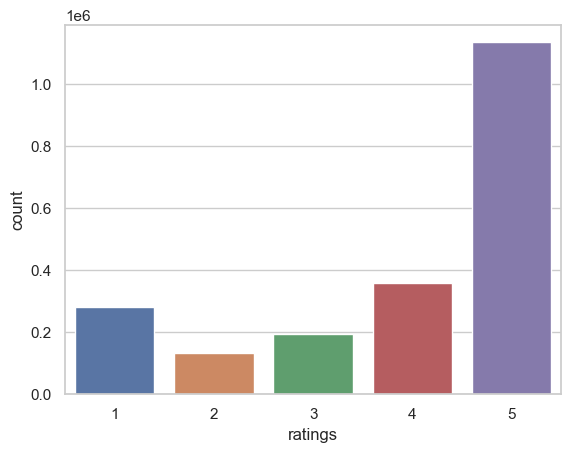

In [86]:
sns.countplot(x= 'ratings', data= raw_data)

#### Most of the reviews are rated with 5, this is an unbalanced dataset

#### Encoding sentiments of reviews based of ratings 
- 0 [Negative]
- 1 [Positive]

In [5]:
raw_data['rating_sentiment'] = raw_data['ratings']

In [7]:
raw_data['rating_sentiment'][raw_data.ratings <= 3] = 0
raw_data['rating_sentiment'][raw_data.ratings >= 4] = 1 

In [9]:
raw_data[['ratings','rating_sentiment']]

,ratings,rating_sentiment
0,1,0
1,3,0
2,4,1
3,1,0
4,4,1
...,...,...
2102190,1,0
2102191,1,0
2102192,5,1
2102193,5,1


In [30]:
raw_data['rating_sentiment'].value_counts(normalize=True)*100

1    71.152819
0    28.847181
Name: rating_sentiment, dtype: float64

#### Review text

In [16]:
from wordcloud import WordCloud,ImageColorGenerator,STOPWORDS
stopwords = set(STOPWORDS)

In [20]:
raw_data['review_text'] = raw_data['review_text'].astype('str')

In [25]:
text = " ".join(words for words in raw_data['review_text'].iloc[:100000])

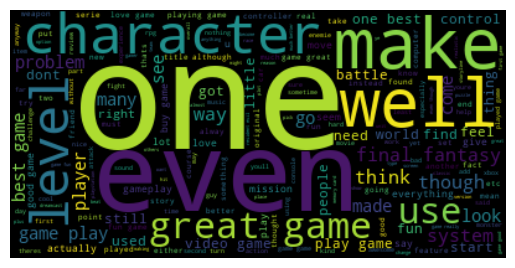

In [26]:
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [32]:
raw_data.to_csv(r'C:\Users\91959\Amazon_reviews_sentiment_analysis\Dataset\preprocessed_data.csv',index=False)

We will encode sentiments for reviews using pretrained roberta model using transformer from the Hugging face

In [4]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch 
from tqdm.notebook import tqdm

In [65]:
sample_data = data.sample(500000)

In [66]:
sample_data.reset_index(drop=True, inplace=True)

In [8]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [10]:
def roberta_model(text):
    encoded_input = tokenizer.encode(text, return_tensors='pt', \
    padding=True, truncation=True,max_length=50, add_special_tokens = True)
    output = model(encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    labels = ['negative', 'neutral', 'positive']
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        return l

In [67]:
sample_data['roberta_sentiment'] = sample_data['review_text'].apply(lambda x: roberta_model(x))

In [74]:
sample_data['roberta_sentiment'].value_counts(normalize= True)*100

positive    62.2020
neutral     22.1566
negative    15.6414
Name: roberta_sentiment, dtype: float64

In [81]:
positive_data = sample_data[sample_data.roberta_sentiment == 'positive']
negative_data = sample_data[sample_data.roberta_sentiment == 'negative']
neutral_data = sample_data[sample_data.roberta_sentiment == 'neutral']

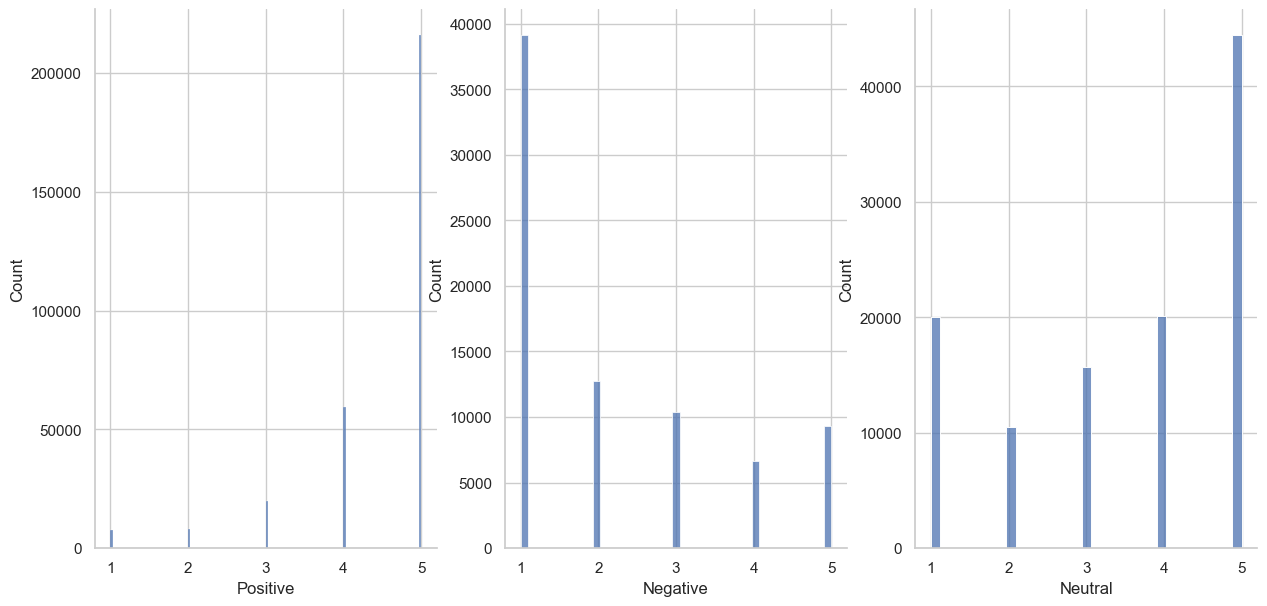

In [83]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols= 3, figsize= (15,7))
sns.histplot(x='ratings', data= positive_data, ax= ax1)
ax1.set_xlabel("Positive")
sns.histplot(x='ratings', data= negative_data, ax=ax2)
ax2.set_xlabel("Negative")
sns.histplot(x='ratings', data= neutral_data, ax= ax3)
ax3.set_xlabel("Neutral")
sns.despine()

OBservation:
- From this we can tell that sentiments are more acurate when using roberta model

In [85]:
sample_data.drop(columns= 'rating_sentiment', inplace= True)

In [91]:
sample_data.to_csv(r'C:\Users\91959\Amazon_reviews_sentiment_analysis\Dataset\final_form.csv',index=False)

In [26]:
final_form = pd.read_csv(r"C:\Users\91959\Amazon_reviews_sentiment_analysis\Dataset\final_form.csv")

In [27]:
final_form['roberta_sentiment'].value_counts(normalize=True)*100

positive    62.2020
neutral     22.1566
negative    15.6414
Name: roberta_sentiment, dtype: float64

From this we can tell this is an imbalanced data set so we cannot use accuracy as evalution metrics 

We only need review text and sentiments features for our model building so we can drop other column

In [28]:
model_data = final_form[['review_text','roberta_sentiment']]

In [29]:
model_data.head()

,review_text,roberta_sentiment
0,bigger screen,neutral
1,played games much fun decided purchase copies ...,positive
2,love battlefield best game already game bought...,positive
3,headset works great awhile playing games sudde...,positive
4,cross play wiiu local play wiiu host great gam...,positive


Encoding the sentiment in numerical values

- Negative as 0
- Neutral as 1
- Positive as 2

In [30]:
model_data.loc[model_data['roberta_sentiment'] == 'neutral' , 'sentiment'] = 1
model_data.loc[model_data['roberta_sentiment'] == 'negative' , 'sentiment'] = 0
model_data.loc[model_data['roberta_sentiment'] == 'positive' , 'sentiment'] = 2

In [31]:
model_data.sentiment.value_counts(normalize=True)*100

2.0    62.2020
1.0    22.1566
0.0    15.6414
Name: sentiment, dtype: float64

In [32]:
model_data.drop(columns='roberta_sentiment', inplace=True)

In [33]:
data = model_data.sample(200000)

In [34]:
data.reset_index(drop=True, inplace=True)

In [35]:
data.sentiment.value_counts(normalize=True)*100

2.0    62.1805
1.0    22.1870
0.0    15.6325
Name: sentiment, dtype: float64

# MODEL BUilding:

## Splitting dataset

In [39]:
training_data , validation_data = train_test_split(data, test_size=0.35, random_state= 223)

In [40]:
validation_data, testing_data = train_test_split(validation_data, test_size= 0.40, random_state=223)

In [41]:
print("Number of rows in training_set",training_data.shape)
print("Number of rows in validation_set",validation_data.shape)
print("Number of rows in testing_set",testing_data.shape)

Number of rows in training_set (130000, 2)
Number of rows in validation_set (42000, 2)
Number of rows in testing_set (28000, 2)


In [42]:
training_data.reset_index(drop= True, inplace=True)
validation_data.reset_index(drop= True, inplace=True)
testing_data.reset_index(drop= True, inplace=True)

In [43]:
training_data.to_csv(r'C:\Users\91959\Amazon_reviews_sentiment_analysis\Dataset\train_data.csv',index=False)
validation_data.to_csv(r'C:\Users\91959\Amazon_reviews_sentiment_analysis\Dataset\validation_data.csv',index=False)
testing_data.to_csv(r'C:\Users\91959\Amazon_reviews_sentiment_analysis\Dataset\test_data.csv',index=False)

## Model Training

In [3]:
## Importing Algorithms

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

In [2]:
train_data = pd.read_csv(r'C:\Users\91959\Amazon_reviews_sentiment_analysis\Dataset\train_data.csv')
val_data = pd.read_csv(r'C:\Users\91959\Amazon_reviews_sentiment_analysis\Dataset\validation_data.csv')
test_data = pd.read_csv(r'C:\Users\91959\Amazon_reviews_sentiment_analysis\Dataset\test_data.csv')

In [6]:
train_data.head()

,review_text,sentiment
0,hard get xbox controller function scripts say ...,1.0
1,defiantly improved ingame skills great mouse,2.0
2,son thrilled get especially happy larger size ...,2.0
3,levels borderlands whats like enough said,1.0
4,happy condition reasonable price,2.0


### Preprocess

In [4]:
x_train = train_data[['review_text']]
y_train = train_data[['sentiment']]
x_val = val_data[['review_text']]
y_val = val_data[['sentiment']]
x_test = test_data[['review_text']]
y_test = test_data[['sentiment']]

#### Converting reviews to matrix of TF-IDF features (Term Frequency and inverse document frequency)

In [8]:
def text_vectorizer(data):
    tf = TfidfVectorizer(ngram_range=(3,3), max_features= 3000 ,strip_accents='unicode')
    tfi = tf.fit_transform(data)
    return pd.DataFrame(tfi.toarray(),columns=tf.get_feature_names_out())

In [9]:
x_train_tfi = text_vectorizer(x_train['review_text'])
x_val_tfi =text_vectorizer(x_val['review_text'])

In [10]:
x_train_tfi

,able get game,able play game,able play games,able play online,able play without,absolutely love game,absolutely loved game,absolutely loves game,acting top notch,actual game play,...,youve ever played,youve never played,youve played game,youve played previous,yr old daughter,yr old grandson,yr old son,zelda link past,zelda twilight princess,zelda wind waker
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
print("shape of final_x_train", x_train_tfi.shape)
print("shape of final_x_val", x_val_tfi.shape)

shape of final_x_train (130000, 3000)
shape of final_x_val (42000, 3000)


In [59]:
    models = {
    "Logistic Regression ": LogisticRegression(max_iter= 1000),
    "Random Forest": RandomForestClassifier(),
    "K Neighbors": KNeighborsClassifier(),
    "Gaussian NB": GaussianNB(),
    "Multinomial NB": MultinomialNB()
    }

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(x_train_tfi,y_train) # To train the model
        with open(r"C:\Users\91959\Amazon_reviews_sentiment_analysis\Artifacts\{}.pickle".format(list(models.keys())[i]),'wb') as f: pickle.dump(model,f)

    #Making predictions
        y_train_pred = model.predict(x_train_tfi)
        y_val_pred = model.predict(x_val_tfi)

    # Training set performance
        model_train_f1 = f1_score(y_train,y_train_pred, average = 'weighted')
        model_train_precision = precision_score(y_train,y_train_pred, average = 'weighted')
        model_train_recall = recall_score(y_train,y_train_pred, average = 'weighted')
    

    #Testing set performance
        model_test_f1 = f1_score(y_val,y_val_pred, average = 'weighted')
        model_test_precision = precision_score(y_val,y_val_pred, average = 'weighted')
        model_test_recall = recall_score(y_val,y_val_pred, average = 'weighted')
    

        print(list(models.keys())[i])


        print("Model Performance for Training set:")

        print("- F1-Score: {:.4f}".format(model_train_f1))
        print("- Precision: {:.4f}".format(model_train_precision))
        print("- Recall: {:.4f}".format(model_train_recall))
        
        print("-----------------------------------")

        print("Model Performance for Validation set:")
        
        print("- F1-Score: {:.4f}".format(model_test_f1))
        print("- Precision: {:.4f}".format(model_test_precision))
        print("- Recall: {:.4f}".format(model_test_recall))
        print('\n')

Logistic Regression 
Model Performance for Training set:
- F1-Score: 0.5342
- Precision: 0.6140
- Recall: 0.6416
-----------------------------------
Model Performance for Validation set:
- F1-Score: 0.4877
- Precision: 0.4778
- Recall: 0.6048


Random Forest
Model Performance for Training set:
- F1-Score: 0.6191
- Precision: 0.7280
- Recall: 0.6881
-----------------------------------
Model Performance for Validation set:
- F1-Score: 0.4870
- Precision: 0.4635
- Recall: 0.5886


K Neighbors
Model Performance for Training set:
- F1-Score: 0.4680
- Precision: 0.6537
- Recall: 0.4546
-----------------------------------
Model Performance for Validation set:
- F1-Score: 0.3764
- Precision: 0.5248
- Recall: 0.3780


Gaussian NB
Model Performance for Training set:
- F1-Score: 0.2924
- Precision: 0.6637
- Recall: 0.3000
-----------------------------------
Model Performance for Validation set:
- F1-Score: 0.2579
- Precision: 0.5263
- Recall: 0.2621


Multinomial NB
Model Performance for Training

In [6]:
with open(r"C:\Users\91959\Amazon_reviews_sentiment_analysis\Artifacts\Random Forest.pickle",'rb') as f:
    model = pickle.load(f)

In [63]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [64]:
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None]
    }

In [65]:
from sklearn.model_selection import GridSearchCV

In [70]:
cv = GridSearchCV(model,parameters,cv=5, scoring='recall')
cv.fit(x_val_tfi,y_val)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 8, 16, 32, None],
                         'n_estimators': [5, 10, 50, 100, 250]},
             scoring='recall')

In [72]:
cv.best_params_

{'max_depth': 2, 'n_estimators': 5}

In [8]:
new_model = MultinomialNB()

In [9]:
new_model.fit(x_train_tfi,y_train)

RandomForestClassifier()

In [10]:
train_pred = new_model.predict(x_train_tfi)

In [14]:
new_test = val_data.sample(15000)
new_test.reset_index(drop=True, inplace=True)
x = new_test[['review_text']]
y = new_test[['sentiment']]
val_tfi = text_vectorizer(x['review_text'])

In [15]:
val_pred = new_model.predict(val_tfi)

In [42]:
print("MultinomialNB")
print()
model_train_f1 = f1_score(y_train,train_pred, average = 'weighted')
model_train_precision = precision_score(y_train,train_pred, average = 'weighted')
model_train_recall = recall_score(y_train,train_pred, average = 'weighted')

print("- F1-Score: {:.4f}".format(model_train_f1))
print("- Precision: {:.4f}".format(model_train_precision))
print("- Recall: {:.4f}".format(model_train_recall))
print("---------------------------------------------")

print("test_performance")
model_val_f1 = f1_score(y,val_pred, average = 'weighted')
model_val_precision = precision_score(y,val_pred, average = 'weighted')
model_val_recall = recall_score(y,val_pred, average = 'weighted')

print("- F1-Score: {:.4f}".format(model_val_f1))
print("- Precision: {:.4f}".format(model_val_precision))
print("- Recall: {:.4f}".format(model_val_recall))


MultinomialNB

- F1-Score: 0.5401
- Precision: 0.6088
- Recall: 0.6413
---------------------------------------------
test_performance
- F1-Score: 0.4855
- Precision: 0.4649
- Recall: 0.5979


#### Ada Boost

In [8]:
x_train_tfi.shape[1]

3000

In [15]:
from sklearn.ensemble import AdaBoostClassifier


ada_classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators= 2000)

In [16]:
ada_classifier.fit(x_train_tfi,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=2000)

In [18]:
import pickle
with open(r"C:\Users\91959\Amazon_reviews_sentiment_analysis\Artifacts\ada_boost.pickle",'wb') as f: pickle.dump(ada_classifier,f)

In [11]:
train_pred = ada_classifier.predict(x_train_tfi)

new_test = val_data.sample(15000)
new_test.reset_index(drop=True, inplace=True)
x = new_test[['review_text']]
y = new_test[['sentiment']]
val_tfi = text_vectorizer(x['review_text'])

val_pred = ada_classifier.predict(val_tfi)

print(" ADA Boost")
print()
model_train_f1 = f1_score(y_train,train_pred, average = 'weighted')
model_train_precision = precision_score(y_train,train_pred, average = 'weighted')
model_train_recall = recall_score(y_train,train_pred, average = 'weighted')

print("- F1-Score: {:.4f}".format(model_train_f1))
print("- Precision: {:.4f}".format(model_train_precision))
print("- Recall: {:.4f}".format(model_train_recall))

print("-----------------------------------------")

print("test_performance")
model_val_f1 = f1_score(y,val_pred, average = 'weighted')
model_val_precision = precision_score(y,val_pred, average = 'weighted')
model_val_recall = recall_score(y,val_pred, average = 'weighted')

print("- F1-Score: {:.4f}".format(model_val_f1))
print("- Precision: {:.4f}".format(model_val_precision))
print("- Recall: {:.4f}".format(model_val_recall))

 ADA Boost

- F1-Score: 0.4878
- Precision: 0.5009
- Recall: 0.6263
-----------------------------------------
test_performance
- F1-Score: 0.4758
- Precision: 0.4033
- Recall: 0.6200


In [24]:
train_pred = ada_classifier.predict(x_train_tfi)

new_test = val_data.sample(15000)
new_test.reset_index(drop=True, inplace=True)
x = new_test[['review_text']]
y = new_test[['sentiment']]
val_tfi = text_vectorizer(x['review_text'])

val_pred = ada_classifier.predict(val_tfi)

print("ADA Boost")
print()
model_train_f1 = f1_score(y_train,train_pred, average = 'weighted')
model_train_precision = precision_score(y_train,train_pred, average = 'weighted')
model_train_recall = recall_score(y_train,train_pred, average = 'weighted')

print("- F1-Score: {:.4f}".format(model_train_f1))
print("- Precision: {:.4f}".format(model_train_precision))
print("- Recall: {:.4f}".format(model_train_recall))

print("------------------------------------")

print("test_performance")
model_val_f1 = f1_score(y,val_pred, average = 'weighted')
model_val_precision = precision_score(y,val_pred, average = 'weighted')
model_val_recall = recall_score(y,val_pred, average = 'weighted')

print("- F1-Score: {:.4f}".format(model_val_f1))
print("- Precision: {:.4f}".format(model_val_precision))
print("- Recall: {:.4f}".format(model_val_recall))

 ADA Boost

- F1-Score: 0.5469
- Precision: 0.6098
- Recall: 0.6429
-----------------------------------------
test_performance
- F1-Score: 0.4794
- Precision: 0.4478
- Recall: 0.5845


#### Random Forest

In [27]:
Random_forest_model = RandomForestClassifier()
Random_forest_model.fit(x_train_tfi,y_train)
train_pred = Random_forest_model.predict(x_train_tfi)

new_test = val_data
#new_test.reset_index(drop=True, inplace=True)
x = new_test[['review_text']]
y = new_test[['sentiment']]
val_tfi = text_vectorizer(x['review_text'])

val_pred = Random_forest_model.predict(val_tfi)

In [28]:
print("Random Forest")
print()
model_train_f1 = f1_score(y_train,train_pred, average = 'weighted')
model_train_precision = precision_score(y_train,train_pred, average = 'weighted')
model_train_recall = recall_score(y_train,train_pred, average = 'weighted')

print("- F1-Score: {:.4f}".format(model_train_f1))
print("- Precision: {:.4f}".format(model_train_precision))
print("- Recall: {:.4f}".format(model_train_recall))
print("---------------------------------------------")

print("test_performance")
model_val_f1 = f1_score(y,val_pred, average = 'weighted')
model_val_precision = precision_score(y,val_pred, average = 'weighted')
model_val_recall = recall_score(y,val_pred, average = 'weighted')

print("- F1-Score: {:.4f}".format(model_val_f1))
print("- Precision: {:.4f}".format(model_val_precision))
print("- Recall: {:.4f}".format(model_val_recall))

Random Forest

- F1-Score: 0.6193
- Precision: 0.7267
- Recall: 0.6881
---------------------------------------------
test_performance
- F1-Score: 0.4866
- Precision: 0.4632
- Recall: 0.5877


###  Based on the Observation we can find that random forest algorithm gives better results than comparing to the other alogirthms. 